# Анализ бизнес-показателей. Приложение Procrastinate Pro+.

***Задача — разобраться в причинах по которым последние несколько месяцев компания терпит убытки и помочь ей выйти в плюс.***

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. 
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

-	лог сервера с данными об их посещениях,
-	выгрузка их покупок за этот период,
-	рекламные расходы.

Предстоит изучить:
-	откуда приходят пользователи и какими устройствами они пользуются,
-	сколько стоит привлечение пользователей из различных рекламных каналов;
-	сколько денег приносит каждый клиент,
-	когда расходы на привлечение клиента окупаются,
-	какие факторы мешают привлечению клиентов.

## Обзор данных.

In [1]:
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
if os.path.exists('/datasets/visits_info_short.csv'):
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
else:
    visits = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Анализ бизнес-показателей/Исходные данные/visits_info_short.csv')
    orders = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Анализ бизнес-показателей/Исходные данные/orders_info_short.csv')
    costs = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Анализ бизнес-показателей/Исходные данные/costs_info_short.csv')


In [3]:
display(visits.head()) # посмотрим таблицу visits
visits.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
display(orders.head(), orders.describe().T) # посмотрим таблицу purchases
orders.info()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,count,mean,std,min,25%,50%,75%,max
User Id,40212.0,4.990295e+11,2.860937e+11,599326.00,2.511324e+11,4.982840e+11,7.433327e+11,9.998954e+11
Revenue,40212.0,5.370608e+00,3.454208e+00,4.99,4.990000e+00,4.990000e+00,4.990000e+00,4.999000e+01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
display(costs.head(), costs.describe().T) # посмотрим таблицу costs
costs.info()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


,count,mean,std,min,25%,50%,75%,max
costs,1800.0,58.609611,107.740223,0.8,6.495,12.285,33.6,630.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


***Описание данных***

В нашем распоряжении три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о покупках, а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits
-	User Id — уникальный идентификатор пользователя,
-	Region — страна пользователя,
-	Device — тип устройства пользователя,
-	Channel — идентификатор источника перехода,
-	Session Start — дата и время начала сессии,
-	Session End — дата и время окончания сессии.

Структура orders
-	User Id — уникальный идентификатор пользователя,
-	Event Dt — дата и время покупки,
-	Revenue — сумма заказа.

Структура costs
-	Channel — идентификатор рекламного источника,
-	Dt — дата проведения рекламной кампании,
-	Costs — расходы на эту кампанию.

In [6]:
# приведём название столбцов к принятому виду
visits = visits.rename(columns={
    'User Id':'user_id', 
    'Region':'region', 
    'Device':'device', 
    'Channel':'channel', 
    'Session Start':'session_start', 
    'Session End':'session_end' 
    })
display(visits.head())

orders = orders.rename(columns={
    'User Id':'user_id', 
    'Event Dt':'event_dt', 
    'Revenue':'revenue' 
    })
display(orders.head())

costs = costs.rename(columns={
    'Channel':'channel', 
    'Dt':'dt', 
    'Costs':'costs' 
    })
display(costs.head())

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [7]:
# проверим на дубликаты
display(visits.duplicated().sum()) 
display(orders.duplicated().sum())
display(costs.duplicated().sum())

0

0

0

Первичный просмотр данных показал, что все три таблицы не имеют пропусков и дубликатов значений. В таблицах есть даты, нужно привести их к соответствующему типу

 ## Подготовка  и приведение данных к нужным типам.

In [8]:
# проверим на содержание столбцы и приведём к единому регистру 
display(visits['channel'].sort_values().unique())
display(costs['channel'].sort_values().unique())
display(visits['region'].sort_values().unique())
display(visits['device'].sort_values().unique())

array(['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado',
       'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner',
       'YRabbit', 'lambdaMediaAds', 'organic'], dtype=object)

array(['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado',
       'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner',
       'YRabbit', 'lambdaMediaAds'], dtype=object)

array(['France', 'Germany', 'UK', 'United States'], dtype=object)

array(['Android', 'Mac', 'PC', 'iPhone'], dtype=object)

In [9]:
# приведём к единому регистру 
visits['channel'] = visits['channel'].str.lower()
costs['channel'] = costs['channel'].str.lower()
visits['device'] = visits['device'].str.lower()

In [10]:
display(visits.head())
display(orders.head())
display(costs.head())

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iphone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iphone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,android,tiptop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,faceboom,113.3
1,2019-05-02,faceboom,78.1
2,2019-05-03,faceboom,85.8
3,2019-05-04,faceboom,136.4
4,2019-05-05,faceboom,122.1


In [11]:
# столбцы с датами приведём к типу datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [12]:
display(visits.info())
display(orders.info())
display(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

In [13]:
round((visits.isna().mean()*100),2) # проверка на пропуски

user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64

In [14]:
round((orders.isna().mean()*100),2) # проверка на пропуски

user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64

In [15]:
round((costs.isna().mean()*100),2) # проверка на пропуски

dt         0.0
channel    0.0
costs      0.0
dtype: float64

***Вывод по подготовке данных к обработке***

В ходе подготовки данных заменили тип данных для дат и привели к нижнему регистру значения всех столбцов, кроме названия стран в столбце region таблицы visits.

# Зададим функции для расчёта и анализа LTV, ROI удержания и конверсии, также функции для визуализации этих метрик.

In [16]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
     # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)


   
    
    return profiles

In [17]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [18]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [19]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
         # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes
        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [20]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [21]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [22]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [23]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Исследовательский анализ данных.

## Создадим пользовательские профили.

In [24]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,faceboom,mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,faceboom,iphone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iphone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,adnonsense,pc,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,yrabbit,iphone,United States,2019-10-02,2019-10-01,False,0.230769


In [25]:
# определим минимальную и максимальную даты привлечения пользователей
min_first_ts = profiles['first_ts'].min()
max_first_ts = profiles['first_ts'].max()
print('Минимальная дата привлечения пользователей:', min_first_ts)
print('Максимальная дата привлечения пользователей:', max_first_ts)

Минимальная дата привлечения пользователей: 2019-05-01 00:00:41
Максимальная дата привлечения пользователей: 2019-10-27 23:59:04


## Проанализируем пользователей разных стран.

In [26]:
profiles_region = (
        profiles.groupby('region')
        .agg(
            {
                'user_id': 'count',
                'payer':'mean'
            }
        )
        .rename(columns={'user_id': 'count_user'})
        .sort_values(by=['count_user'], ascending=False)
        .reset_index()
)
profiles_region

,region,count_user,payer
0,United States,100002,0.069019
1,UK,17575,0.039829
2,France,17450,0.037994
3,Germany,14981,0.041119


## Проанализируем, какие устройства предпочитают пользователи.

In [27]:
profiles_device = (
        profiles.groupby('device')
        .agg(
            {
                'user_id': 'count',
                'payer':'mean'
            }
        )
        .rename(columns={'user_id': 'count_user'})
        .sort_values(by=['count_user'], ascending=False)
        .reset_index()
)
profiles_device

,device,count_user,payer
0,iphone,54479,0.062079
1,android,35032,0.058518
2,pc,30455,0.050468
3,mac,30042,0.063644


## Проанализируем рекламные источники и определим каналы привлечения платящих пользователей.

In [28]:
profiles_channel = (
        profiles.groupby('channel')
        .agg(
            {
                'user_id': 'count',
                'payer':'mean'
            }
        )
        .rename(columns={'user_id': 'count_user'})
        .sort_values(by=['payer'], ascending=False)
        .reset_index()
)
profiles_channel

,channel,count_user,payer
0,faceboom,29144,0.122049
1,adnonsense,3880,0.113402
2,lambdamediaads,2149,0.104700
3,tiptop,19561,0.096007
4,rocketsuperads,4448,0.079137
5,wahoonetbanner,8553,0.052964
6,yrabbit,4312,0.038265
7,mediatornado,4364,0.035747
8,leapbob,8553,0.030633
9,opplecreativemedia,8605,0.027077


***Вывод по исследовательскому анализу***

Создав и проанализировав профили всех пользователей приложения, можно сказать:

- что первые  пользователи появились 2019-05-01
- пользователи приходят из четырёх стран United States	100002 чел., UK	17575 чел., France	17450чел. и	Germany	14981чел.
- доля платящих пользователей больше всего в Соединённых Штатах - почти 7%
- наиболее многочисленная группа (54479 чел.) пользуется iphon для входа в приложение, при этом доля платящих среди них составляет 6.2%, что чуть меньше чем доля пользователей с mac. У которых доля платящих 6.4%, но численностьгораздо ниже - 30042 чел.
- что касается источников привлечения, то самая многочисленная группа - это organic, но доля платящих там низкая (2%), а вот из пользователей пришедших из faceboom  (29144 чел.) платят 12.2%

На первый взгляд выгодными пользователями для платформы стали пользователи из Соединённых Штатов, пользующаяся iphon, привлечённые через faceboom.

# Маркетинг. Рассчитаем средний САС.

## Расходы на маркетинг.

In [29]:
# распределение трат по источникам
costs_sum_channel = (
        costs.groupby('channel')
        .agg(
            {
                'costs':'sum'
            }
        )
        .sort_values(by=['costs'], ascending=False)
        .reset_index()
)
costs_sum_channel

,channel,costs
0,tiptop,54751.30
1,faceboom,32445.60
2,wahoonetbanner,5151.00
3,adnonsense,3911.25
4,opplecreativemedia,2151.25
5,rocketsuperads,1833.00
6,leapbob,1797.60
7,lambdamediaads,1557.60
8,mediatornado,954.48
9,yrabbit,944.22


In [30]:
# всего потрачено на маркетинг
costs_sum = costs_sum_channel['costs'].sum()
costs_sum

105497.3

In [31]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month # добавим столбец с месяцем
costs.head()

,dt,channel,costs,month
0,2019-05-01,faceboom,113.3,5
1,2019-05-02,faceboom,78.1,5
2,2019-05-03,faceboom,85.8,5
3,2019-05-04,faceboom,136.4,5
4,2019-05-05,faceboom,122.1,5


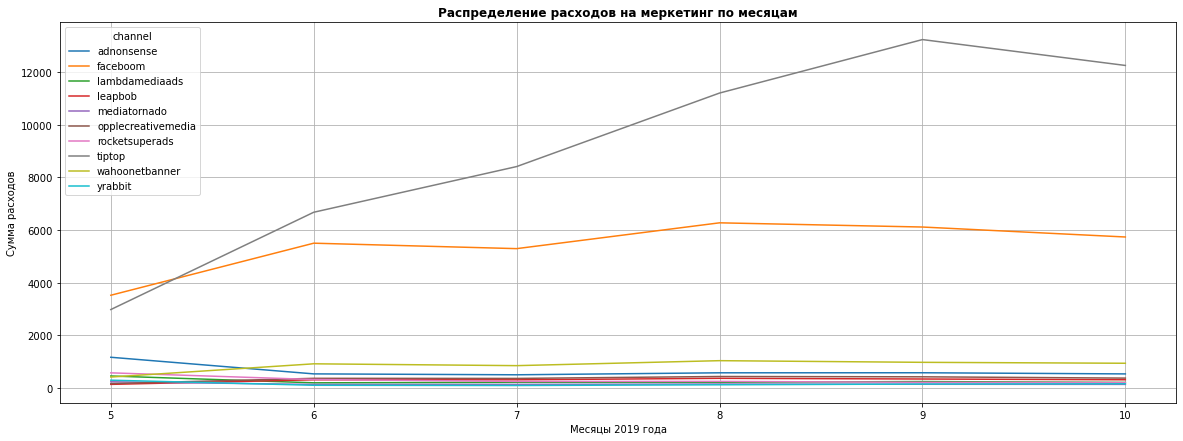

In [32]:
# построим графики расходов на маркетинг по месяцам
(costs.pivot_table(index=['month'], columns='channel', values=['costs'], aggfunc='sum')
     .sort_values('month', ascending=True)
     .reset_index()
     .plot(x='month', y='costs', kind='line', grid=True, figsize=(20, 7))
);
plt.title('Распределение расходов на меркетинг по месяцам', fontweight="bold")
plt.xlabel('Месяцы 2019 года')
plt.ylabel('Сумма расходов')
plt.show()

## Расчёт стоимости привлечения одного пользователя. Расчёт среднего САС.

In [33]:
count_user = profiles.query('channel != "organic"')['user_id'].count() # всего пользователей привлечённых рекламой
CAC_mean = costs_sum / count_user # средний САС на одного пользователя для всего проекта
CAC_mean.round(2)

1.13

In [34]:
# сколько в среднем стоило привлечение одного пользователя из каждого источника
acquisition_cost = profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)
acquisition_cost

channel
tiptop                2.799003
faceboom              1.113286
adnonsense            1.008054
lambdamediaads        0.724802
wahoonetbanner        0.602245
rocketsuperads        0.412095
opplecreativemedia    0.250000
yrabbit               0.218975
mediatornado          0.218717
leapbob               0.210172
organic               0.000000
Name: acquisition_cost, dtype: float64

***Вывод по расходам на маркетинг***

Из вссех расходов на рекламу в 105 497.3 у.е. больше всего было потрачено на привлечение пользователей по двум каналам:
tiptop	54 751.30 у.е. и faceboom	32 445.60 у.е. На графике распределения наглядно видно, как отличаются расходы по этим каналам от остальных источников. Особенно выделяется канал tiptop в который до сентября вложения стабильно повышались.

Посчитав стоимость привлечения одного клиента по источникам получили, что стоимость пользователя пришедшего из tiptop 2.8 у.е., что почти в 2.5 раза выше следующего по вложениям канала faceboom 1.11 у.е. Очень дорогие пользователи.

Если соотнести все расходы на рекламу и всех пользователей, то САС получится 1.13у.е.

# Оценка окупаемости рекламы.

## Проанализируем общую окупаемость рекламы.

In [35]:
# задаём момент и горизонт анализа данных
observation_date = datetime(2019, 10, 1).date()
horizon_days = 14

In [36]:
# уберём данные по organic пользователям, т.к. стоимостьих привлечения = 0
profiles = profiles.query('channel != "organic"')

In [37]:
# считаем LTV и ROI для вех пользователей
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

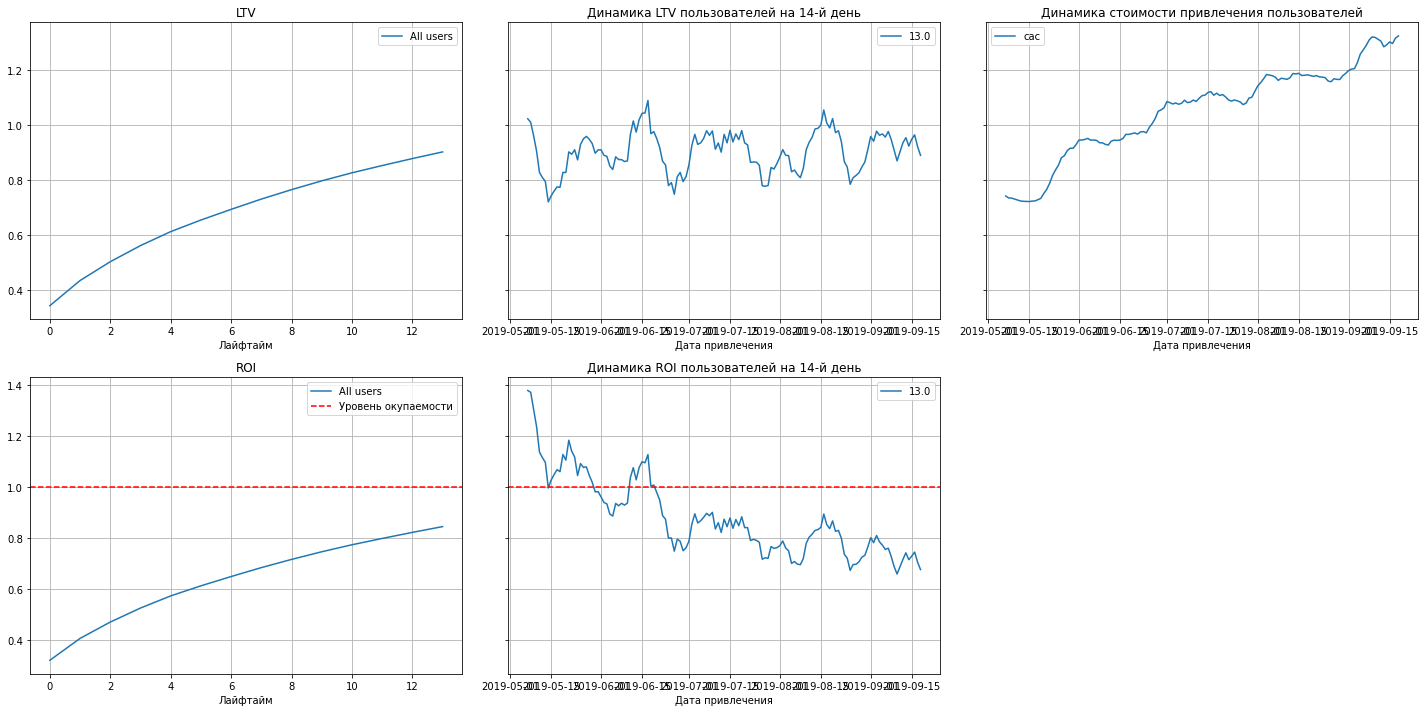

In [38]:
# с помощью функции для визуализации LTV и ROI построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:

- pеклама не окупается. 
- ROI в конце второй недели — чуть выше 80%.
- стоимомость привлечения пользователей растёт
- LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
- в июле ROI окончательно падает и уже не поднимается выше САС. Возможно связано с ростом расходов на рекламу в tiptop. 

## Проанализируем окупаемость рекламы c разбивкой по рекламным каналам.

In [39]:
# с помощью функции рассчитаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

In [40]:
# сгладим фреймы динамики LTV и ROI с недельным окном
ltv_history = filter_data(ltv_history, 7)
roi_history = filter_data(roi_history, 7)

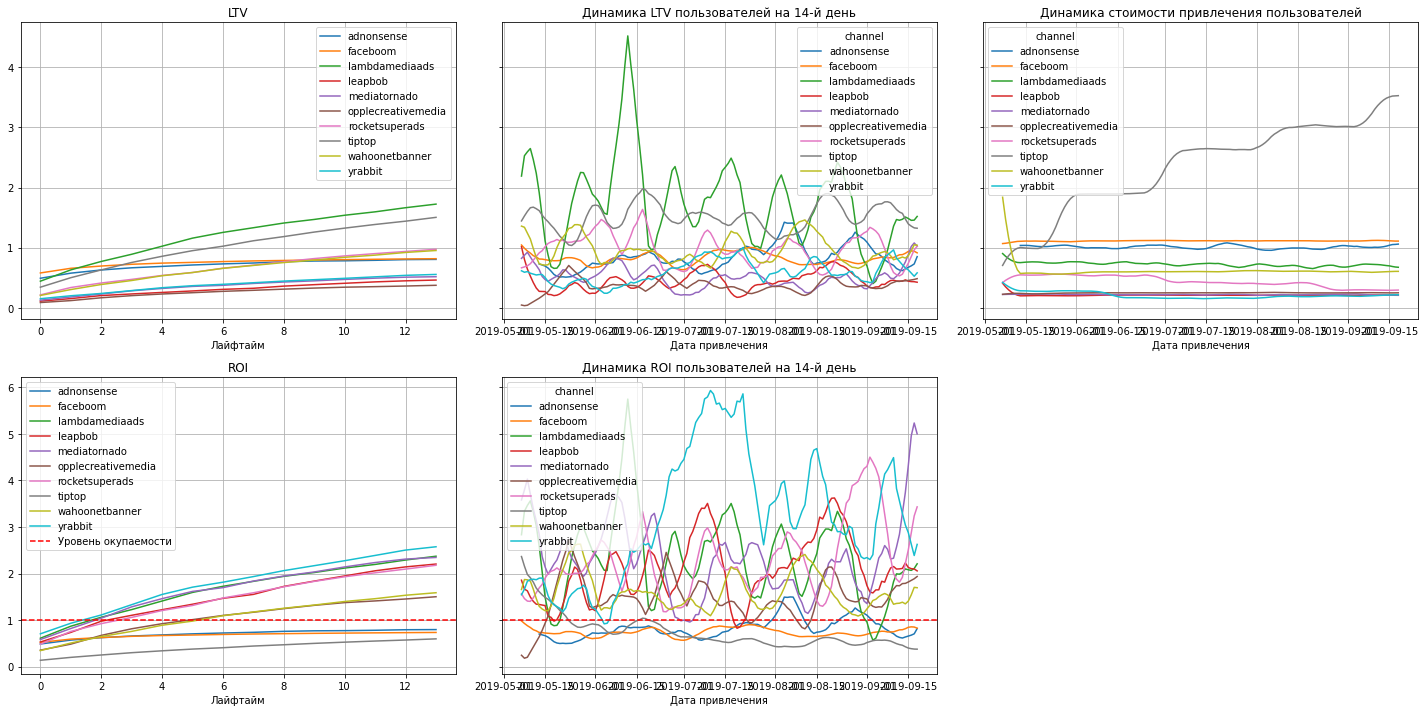

In [41]:
# с помощью функции для визуализации LTV и ROI построим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) 

По графикам можно сделать такие выводы:

- LTV пользователей привлеченных по каналу lambdamediaads самая высокая. Канал tiptop тоже показывает не плохой LTV
- динамика LTV пользователей привлечённых по каналу lambdamediaads на 14 день стабильно выше на всём протяжении иследуемого периода, но в сентябре падает. Остальные каналы достаточно стабильны. 
- стоимомость привлечения пользователей растёт для канала tiptop, начиная с мая и там же, в мае, падает для канала wahoonetbanner и остаётся постоянной на протяжении оставшегося периода. Остальные каналы стабильны.
- каналы tiptop, adnonsense и faceboom не выходят за САС, т.е. затраты на рекламу не окупаются. Лучше всех показатель ROI для канала yrabbit.
- на графике динамики ROI бросается в глаза рост в июне окупаемости инвестиций в канал yrabbit и снижение для канала tiptop (который весь оставшийся период не поднялся выше САС). Для канала faceboom ROI не превысила САС ни разу. Канал adnonsense показывал окупаемость в августе и сентябре, остьное время тоже не окупался 

## Проанализируем окупаемость рекламы c разбивкой по странам.

In [42]:
# с помощью функции рассчитаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

In [43]:
# сгладим фреймы динамики LTV и ROI с недельным окном
ltv_history = filter_data(ltv_history, 7)
roi_history = filter_data(roi_history, 7)

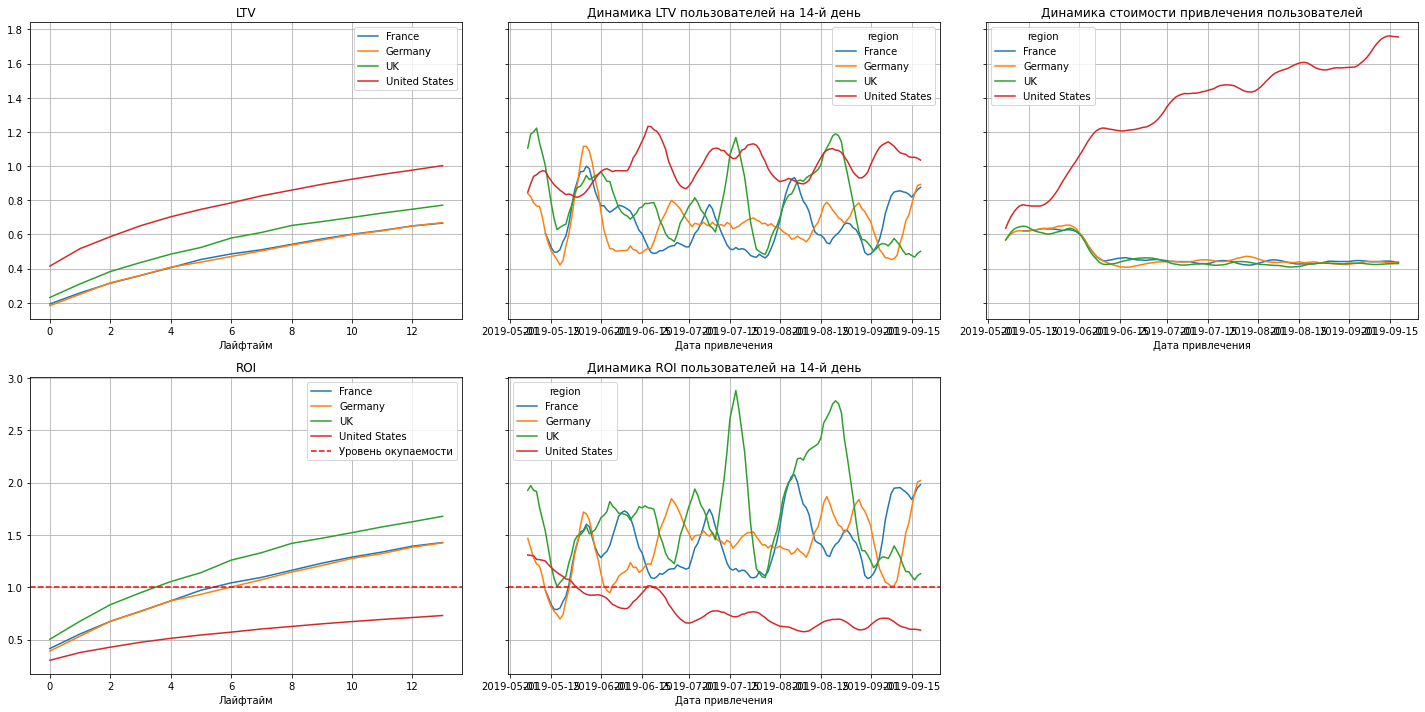

In [44]:
# с помощью функции для визуализации LTV и ROI построим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) 

По графикам можно сделать такие выводы:

- LTV пользователей из Соединённых Штатов самая высокая. Пользователи Великобритании тоже показывает не плохой LTV
- динамика LTV пользователей достаточно стабильна. 
- стоимомость привлечения пользователей из Соединённых Штатов растёт и сильно выбиватся из общей картины. Стоимость же привлечения пользователей из остальных стран снижается в июне и остаётся стабильно постоянной и прктически одинаковой для всех.
- окупаемость инвестиций для пользователей из Великобритании наступает примерно на третий, для Франции и Германии на шестой  день, а пользователи из Соединённых Штатов не окупаются в течении 14 дней.
- на графике динамики ROI бросается в глаза падение окупаемости инвестиций для пользователей из Соединённых Штатов на фоне хороших показателей других стран

## Построим и изучим графики конверсии и удержания c разбивкой по устройствам.

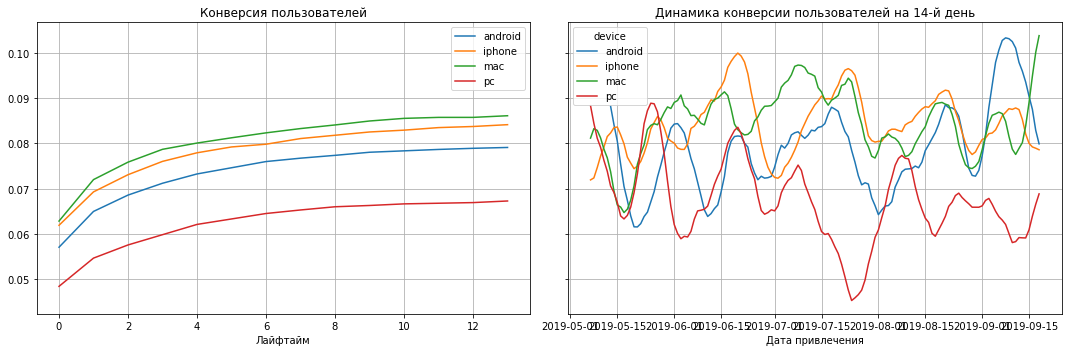

In [45]:
# используя функцию рассчитаем конверсию и построим графики с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)
# сгладим фрейм динамики с недельным окном
conversion_history = filter_data(conversion_history, 7)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи mac и iphone конвертируются очень хорошо, причём постоянно. Хуже обстоит с пользователями на рс. Стоит проверить версию сайта для рс.

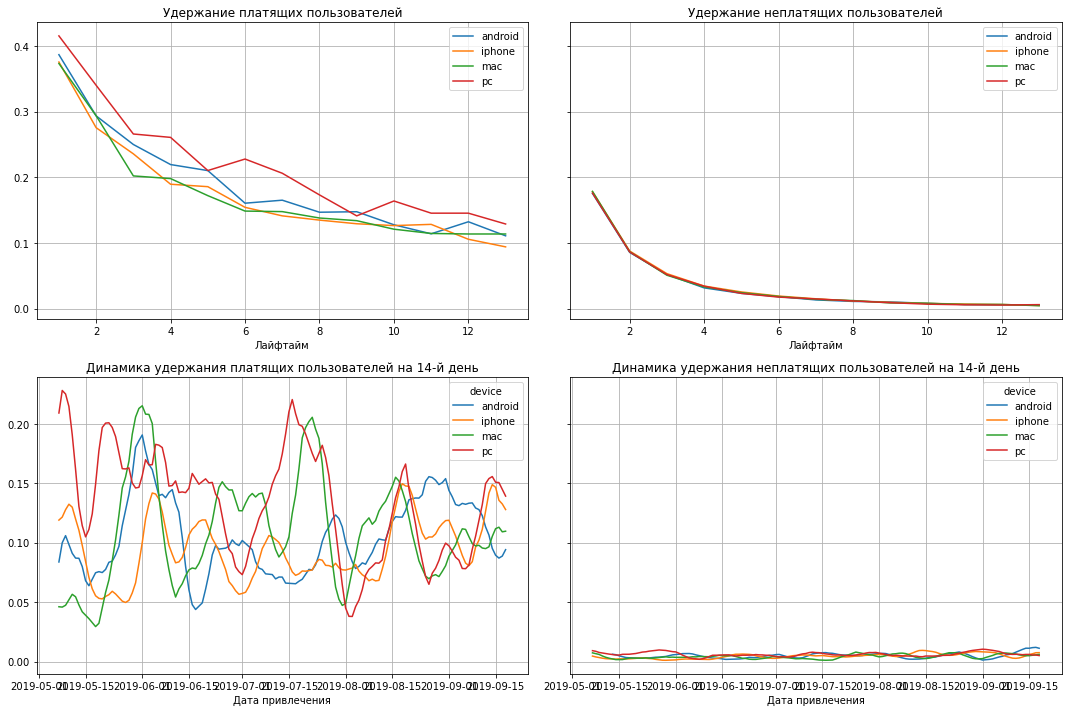

In [46]:
# используя функцию рассчитаем удержание и построим графики с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)
# сгладим фрейм динамики с недельным окном
retention_history = filter_data(retention_history, 7)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей на pc не сильно отличается от удержания пользователей с друми устройствами. Значит тип устройства не особо влияет на удержание платящих пользователей. 

Неплатящие пользователи показывают практически равные показатели удержания и в целом и в динамике 14 дней.

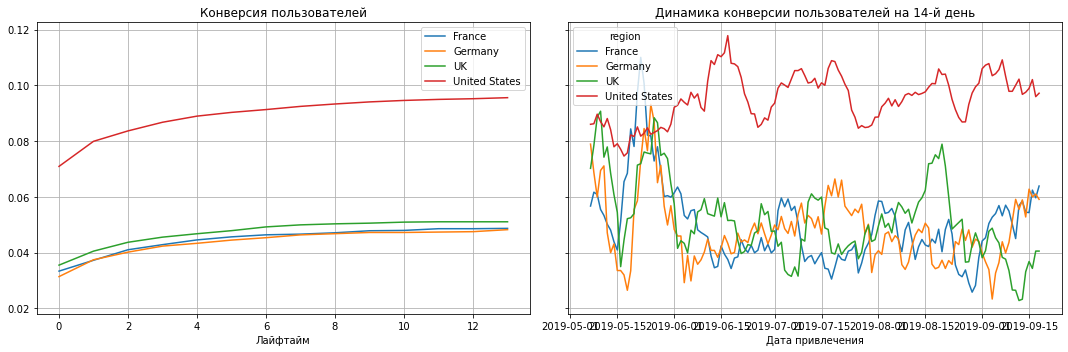

In [47]:
# используя функцию рассчитаем конверсию и построим графики с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей в покупатели из Соединённых Штатов сильно превышает конверсию всех остальных стран. Возможно для Европейских стран нужна адаптация платформы, что то их не так цепляет, как пользователей из Соединённых Штатов.

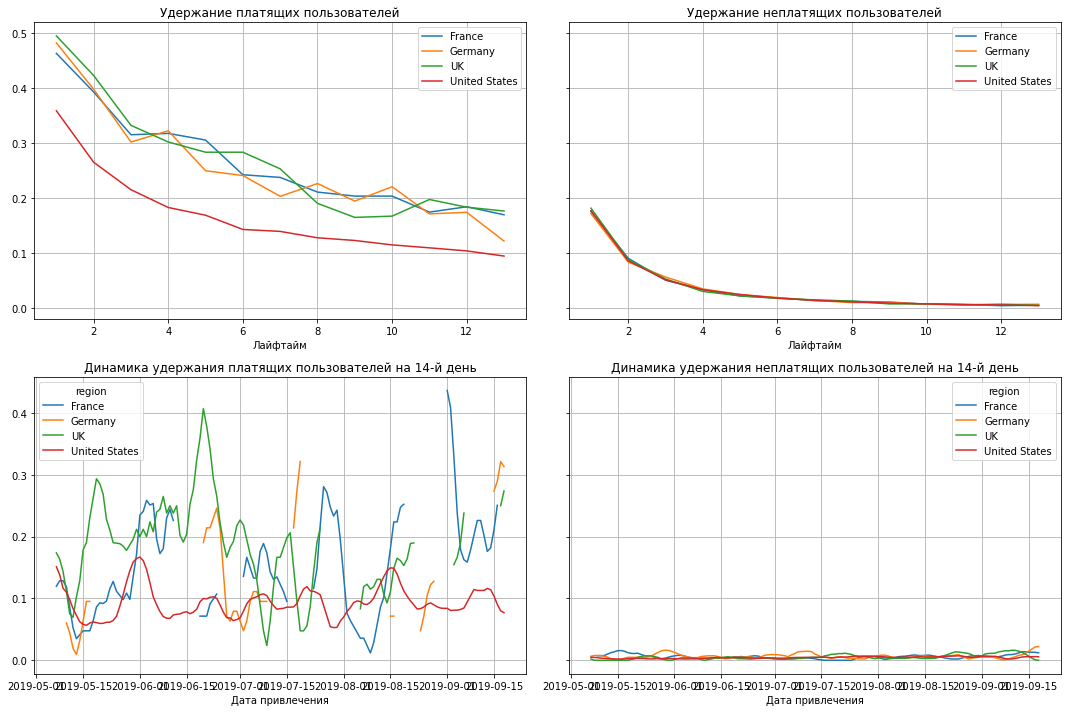

In [48]:
# используя функцию рассчитаем удержание и построим графики с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)
# сгладим фрейм динамики с окном в 3 дня
retention_history = filter_data(retention_history, 3)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей из Соединённых Штатов сильно ниже всех остальных, но стабильно на протяжении двух недель. Пользователи из Великобритании в июле и дальше перестали пользоваться приложением в течении 14 дней. Для пользователей из Германии 14 дней в приложении вообще не частое явление. Было бы не плохо посмотреть какиее были изменения в приложении  с 15 июня. Возможно, что они повлияли на удержание платящих клиентов.

Удержание неплатящих клиентов и его динамика практически равны для всех стран.

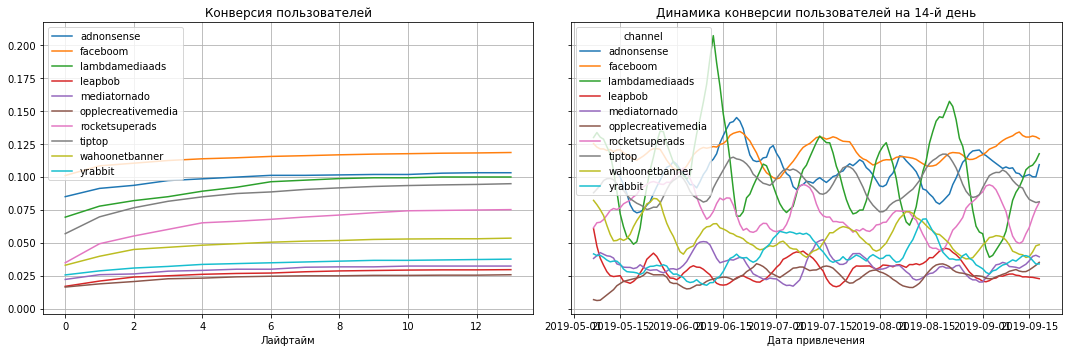

In [49]:
# используя функцию рассчитаем конверсию и построим графики с разбивкой по каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)
# сгладим фрейм динамики с окном в 7 дней
conversion_history = filter_data(conversion_history, 7)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Хорошую конверсию показывают пользователи привлечённые по каналам faceboom, adnonsense и lambdamediaads.

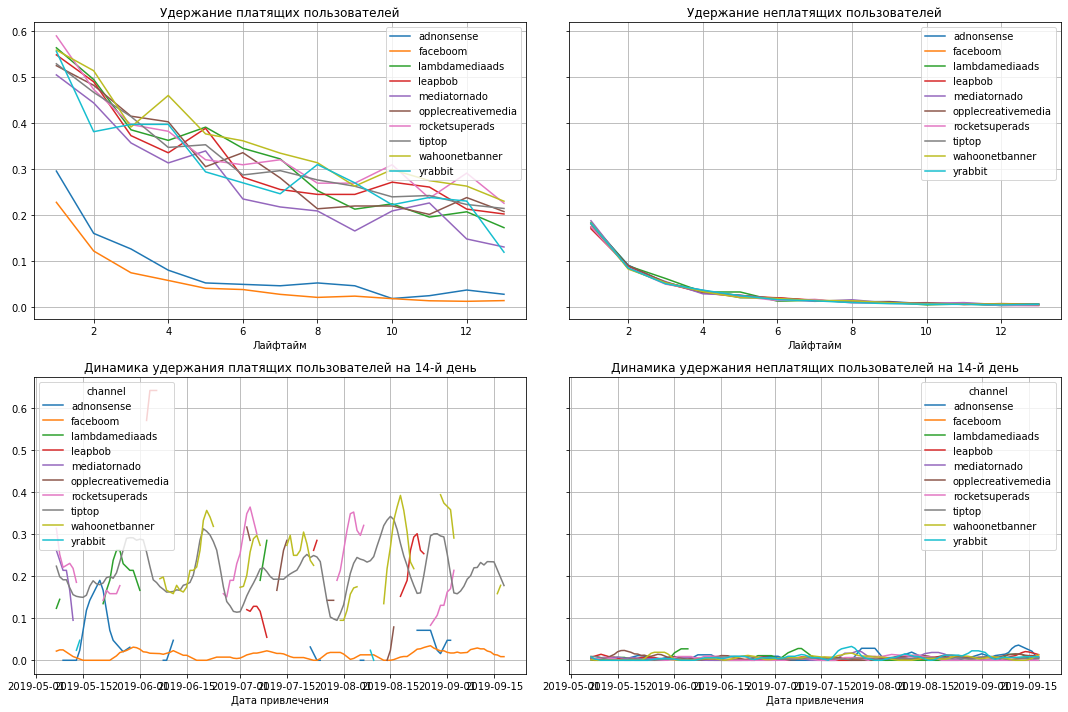

In [50]:
# используя функцию рассчитаем удержание и построим графики с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)
# сгладим фрейм динамики с окном в 3 дня
retention_history = filter_data(retention_history, 3)

plot_retention(retention_grouped, retention_history, horizon_days) 

Проваливаются по удержанию платящих пользователей каналы faceboom и adnonsense. В динамике наиболее стабильны пользователи привлечённые по каналу tiptop.
Удержание неплатящих клиентов и его динамика практически равны для всех каналов.

Для всех каналов привлечения кроме tiptop и faceboom, характерно краткосрочное пользование приложением. Возможно в приложении есть возможность делиться с друзьями в соцсетях (если tiptop и faceboom соцсети). Возможно можно добавить подобную возможность рассказывать друзьям для пользователей из остальных каналов.

***Вывод по оценке окупаемости реламы***

- pеклама не окупается.
- ROI в конце второй недели — чуть выше 80%.
- стоимомость привлечения пользователей растёт
- в июле ROI окончательно падает и уже не поднимается выше САС. Возможно связано с ростом расходов на рекламу в tiptop.
- LTV пользователей привлеченных по каналу lambdamediaads самая высокая. Канал tiptop тоже показывает не плохой LTV
- динамика LTV пользователей привлечённых по каналу lambdamediaads на 14 день стабильно выше на всём протяжении иследуемого периода. Остальные каналы достаточно стабильны. 
- стоимомость привлечения пользователей растёт для канала tiptop, начиная с мая.
- каналы tiptop, adnonsense и faceboom не выходят за САС, т.е. затраты на рекламу не окупаются. Лучше всех показатель ROI для канала yrabbit.
- на графике динамики ROI бросается в глаза рост в июне окупаемости инвестиций в канал yrabbit и снижение для канала tiptop (который весь оставшийся период не поднялся выше САС). Для канала faceboom ROI не превысила САС ни разу. Канал adnonsense показывал окупаемость в августе и сентябре, остьное время тоже не окупался 
- LTV пользователей из Соединённых Штатов самая высокая. Пользователи Великобритании тоже показывает не плохой LTV
- динамика LTV пользователей достаточно стабильна. 
- стоимомость привлечения пользователей из Соединённых Штатов растёт и сильно выбиватся из общей картины. Стоимость же привлечения пользователей из остальных стран снижается в июне и остаётся стабильно постоянной и прктически одинаковой для всех.
- окупаемость инвестиций для пользователей из Великобритании наступает примерно на третий, для Франции и Германии на шестой  день, а пользователи из Соединённых Штатов не окупаются в течении 14 дней.
- на графике динамики ROI бросается в глаза падение окупаемости инвестиций для пользователей из Соединённых Штатов на фоне хороших показателей других стран
- удержание платящих пользователей на pc не сильно отличается от удержания пользователей с друми устройствами. Значит тип устройства не особо влияет на удержание платящих пользователей. 
- удержание платящих пользователей из Соединённых Штатов сильно ниже всех остальных, но стабильно на протяжении двух недель. Пользователи из Великобритании в июле и дальше перестали пользоваться приложением в течении 14 дней. Для пользователей из Германии 14 дней в приложении вообще не частое явление. Было бы не плохо посмотреть какиее были изменения в приложении  с 15 июня. Возможно, что они повлияли на удержание платящих клиентов.

## Посмотрим на рекламу для Соединённых Штатов.

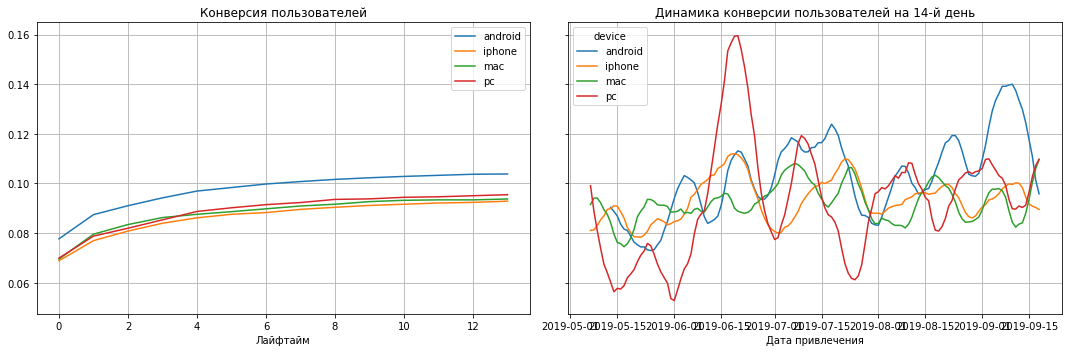

In [51]:
profiles_US = profiles.query('region == "United States"')
# используя функцию рассчитаем конверсию и построим графики с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_US, orders, observation_date, horizon_days, dimensions=['device']
)
# сгладим фрейм динамики с недельным окном
conversion_history = filter_data(conversion_history, 7)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

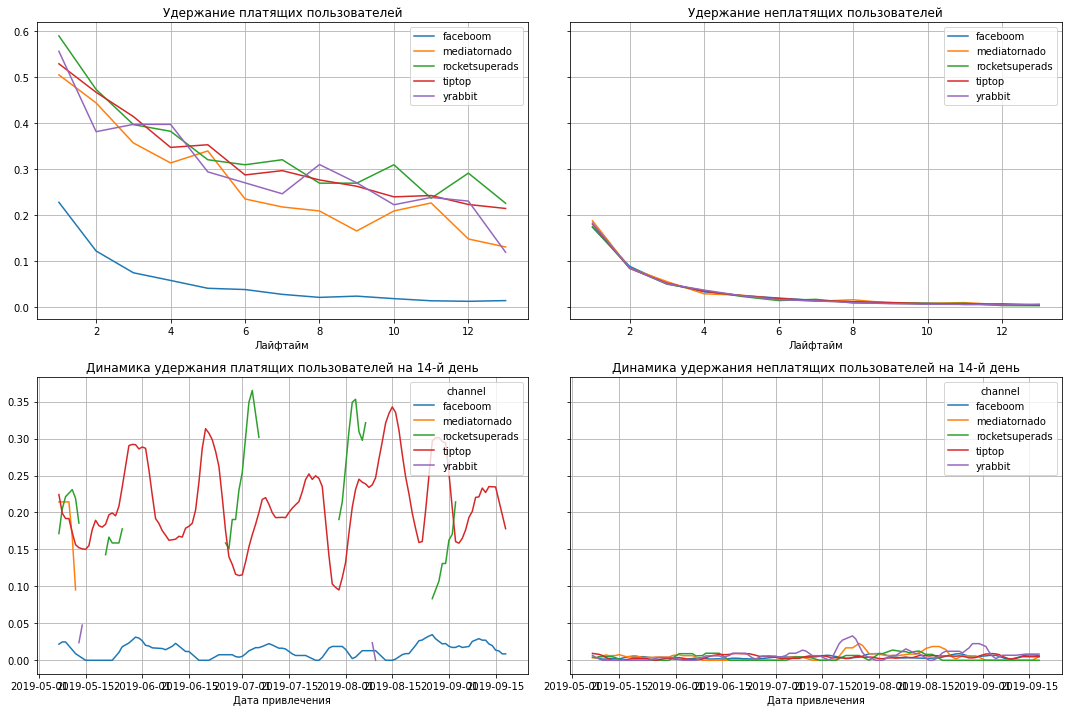

In [52]:
# используя функцию рассчитаем удержание и построим графики с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_US, visits, observation_date, horizon_days, dimensions=['channel']
)
# сгладим фрейм динамики с окном в 3 дня
retention_history = filter_data(retention_history, 3)

plot_retention(retention_grouped, retention_history, horizon_days) 

Для Соединённых Штатов характерна конверсия пользователей с заходящих на платформу с android выше, чем с остальных устройств. При этом динамика конверсии отлична у пользователей на рс. Стоит посмотреть на версию сайта для рс.

Что касается каналов привлечения пользователей на платформу, то среди платящих пользователей удержание наихудшее для канала faceboom. Так, что там вкладываться в рекламу на их канале не стоит. Кроме tiptop, показывающей хорошую динамику удержания, стоит присмотреться к rocketsuperads, с условием доработки привлекательных моментов для этих пользователей. Возможно это будет возможность делиться в сети в друзьями какими то достижениями и т.д.

# Выводы.

## Причины неэффективности привлечения пользователей.

- больше половины бюджета на рекламу было вложено в канал tiptop, по которому окупаемости инвестиций не случилось ни разу за весь период работы. Стоило пересмотреть траты.
- при высокой конверсии пользователей из Соединённых Штатов низкое удержание платящих клиентов. Возможно нужно разработать программу лояльности.
- низкая конверсия пользователей с рс, при хорошей динамике удержания платящих пользователей. Возможно нужно оптимизировать работу версии сайта для рс.
- нестабильные показатели удержания пользователей из Франции, Германии и Великобритании. 
- пользователи привлечённые через faceboom хорошо конвертируются, причём постоянно, но их удержание очень низкое.

## Рекомендации для отдела маркетинга.

- Стоило бы пересмотреть траты на рекламу в канале tiptop, в пользу других. Например канал lambdamediaads (на сегодняшний день окупаемость происходит на второй день, удержание платящих клиентов не плохое).
- Возможно нужно разработать программу лояльности для удержания всех клиентов, в первую очередь клиентов из Соединённых Штатов. Их на платформе большая чать, они хорошо конвертируются.
- Необходимо разобраться с низкой конверсией пользователе на рс. Возможно, что мобильная версия работает лучше, быстрее.
- Возможно для Европы и Америки характерны разные тренды и нужно это отразить на платформе. 
- Для пользователей из faceboom возможно стоит добавить возможностей делиться с друзьями своим прогрессом или другой какой-то информацией из приложения.
- В Соединённых Штатах не стоит вкладываться в рекламу на канале faceboom, пользователи, пришедшие с него показывают там слабое удержание. Стоит привлечь новых пользователей канала rocketsuperads.
- В Европе нужно привлечь новых пользователей канала lambdamediaads.